In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import matplotlib.pyplot as plt

temp_rain_soil = pd.read_csv("../../AucklandCouncilOpenData_08June24/temp_rain_soil_Auckland_2015-10-21to2024-06-08.csv", index_col='Timestamp (UTC+12:00)', parse_dates=True)
temp_rain_soil.head()

,Temp,Rain(mm),SoilMoist,SoilTemp
Timestamp (UTC+12:00),,,,
2018-07-07 11:00:00,14.0,0.0,37.51600,10.400
2018-07-07 12:00:00,15.0,0.0,37.52375,10.600
2018-07-07 13:00:00,16.0,0.0,37.57200,10.700
2018-07-07 14:00:00,16.0,0.0,37.34300,10.725
2018-07-07 15:00:00,16.0,0.0,37.35050,10.950


In [2]:
temp_rain_soil.tail()

,Temp,Rain(mm),SoilMoist,SoilTemp
Timestamp (UTC+12:00),,,,
2023-08-23 00:00:00,11.0,0.0,50.77650,11.90
2023-08-23 01:00:00,11.0,0.0,50.82350,11.90
2023-08-23 02:00:00,11.0,0.0,50.82475,11.90
2023-08-23 03:00:00,11.0,0.0,50.85500,11.65
2023-08-23 04:00:00,10.0,0.0,50.95325,11.60


In [3]:
def create_lag_features(data, lag_days):
    for i in range(1, lag_days + 1):
        for column in ['Temp', 'Rain(mm)']:
            data[f'lag_{column}_{i}'] = data[column].shift(i)
    data.dropna(inplace=True)
    return data


In [4]:
lagd_14 = create_lag_features(temp_rain_soil, 14)
lagd_14.head()

,Temp,Rain(mm),SoilMoist,SoilTemp,lag_Temp_1,lag_Rain(mm)_1,lag_Temp_2,lag_Rain(mm)_2,lag_Temp_3,lag_Rain(mm)_3,...,lag_Temp_10,lag_Rain(mm)_10,lag_Temp_11,lag_Rain(mm)_11,lag_Temp_12,lag_Rain(mm)_12,lag_Temp_13,lag_Rain(mm)_13,lag_Temp_14,lag_Rain(mm)_14
Timestamp (UTC+12:00),,,,,,,,,,,,,,,,,,,,,
2018-07-08 01:00:00,12.0,0.0,37.01475,11.20,13.0,0.0,13.0,0.0,13.0,0.0,...,16.0,0.0,16.0,0.0,16.0,0.0,15.0,0.0,14.0,0.0
2018-07-08 02:00:00,12.0,0.0,37.16300,11.15,12.0,0.0,13.0,0.0,13.0,0.0,...,15.0,0.0,16.0,0.0,16.0,0.0,16.0,0.0,15.0,0.0
2018-07-08 03:00:00,13.0,0.0,37.04450,11.10,12.0,0.0,12.0,0.0,13.0,0.0,...,15.0,0.0,15.0,0.0,16.0,0.0,16.0,0.0,16.0,0.0
2018-07-08 04:00:00,13.0,0.0,37.07950,11.10,13.0,0.0,12.0,0.0,12.0,0.0,...,15.0,0.0,15.0,0.0,15.0,0.0,16.0,0.0,16.0,0.0
2018-07-08 05:00:00,13.0,0.0,37.03725,11.10,13.0,0.0,13.0,0.0,12.0,0.0,...,14.0,0.0,15.0,0.0,15.0,0.0,15.0,0.0,16.0,0.0


In [5]:

def evaluate_model(data, sequence_length):
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    X_sequences = []
    y_sequences = []

    for i in range(len(scaled_data) - sequence_length):
        X_sequences.append(scaled_data[i:i + sequence_length])
        y_sequences.append(scaled_data[i + sequence_length, 1:3])  # Predicting Rain(mm) and SoilMoist

    X_sequences = np.array(X_sequences)
    y_sequences = np.array(y_sequences)

    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(sequence_length, X_sequences.shape[2])),
        tf.keras.layers.LSTM(50),
        tf.keras.layers.Dense(2)  # Predicting 2 values: Rain(mm) and SoilMoist
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(X_sequences, y_sequences, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
    val_loss = min(history.history['val_loss'])

    return val_loss

In [6]:
# Find the best lag day
best_val_loss = float('inf')
best_lag_day = None

for lag_days in range(1, 14): 
    temp_rain_soil_copy = temp_rain_soil.copy()
    temp_rain_soil_lagged = create_lag_features(temp_rain_soil_copy, lag_days)
    val_loss = evaluate_model(temp_rain_soil_lagged, sequence_length=30)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_lag_day = lag_days

print(f"Best lag day: {best_lag_day} with validation loss: {best_val_loss}")

f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: U

Best lag day: 5 with validation loss: 0.8509840965270996


In [7]:
temp_rain_soil = create_lag_features(temp_rain_soil, best_lag_day)
temp_rain_soil.head()

,Temp,Rain(mm),SoilMoist,SoilTemp,lag_Temp_1,lag_Rain(mm)_1,lag_Temp_2,lag_Rain(mm)_2,lag_Temp_3,lag_Rain(mm)_3,...,lag_Temp_10,lag_Rain(mm)_10,lag_Temp_11,lag_Rain(mm)_11,lag_Temp_12,lag_Rain(mm)_12,lag_Temp_13,lag_Rain(mm)_13,lag_Temp_14,lag_Rain(mm)_14
Timestamp (UTC+12:00),,,,,,,,,,,,,,,,,,,,,
2018-07-08 06:00:00,14.0,0.0,37.01425,11.075,13.0,0.0,13.0,0.0,13.0,0.0,...,14.0,0.0,14.0,0.0,15.0,0.0,15.0,0.0,15.0,0.0
2018-07-08 07:00:00,14.0,0.0,36.99425,11.050,14.0,0.0,13.0,0.0,13.0,0.0,...,14.0,0.0,14.0,0.0,14.0,0.0,15.0,0.0,15.0,0.0
2018-07-08 08:00:00,14.0,0.0,36.87725,11.025,14.0,0.0,14.0,0.0,13.0,0.0,...,13.0,0.0,14.0,0.0,14.0,0.0,14.0,0.0,15.0,0.0
2018-07-08 09:00:00,14.0,0.0,36.98375,11.025,14.0,0.0,14.0,0.0,14.0,0.0,...,13.0,0.0,13.0,0.0,14.0,0.0,14.0,0.0,14.0,0.0
2018-07-08 10:00:00,15.0,0.0,36.82200,11.050,14.0,0.0,14.0,0.0,14.0,0.0,...,13.0,0.0,13.0,0.0,13.0,0.0,14.0,0.0,14.0,0.0


In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(temp_rain_soil)

In [9]:
import numpy as np

def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length, 1:3])  # Predicting Rain(mm) and SoilMoist
    return np.array(X), np.array(y)

sequence_length = 30
X_sequences, y_sequences = create_sequences(scaled_data, sequence_length)

In [10]:
train_size = int(len(X_sequences) * 0.7)
train_X, test_X = X_sequences[:train_size], X_sequences[train_size:]
train_y, test_y = y_sequences[:train_size], y_sequences[train_size:]

In [11]:
train_size = int(len(X_sequences) * 0.7)
last_day_train_set = temp_rain_soil.index[train_size - 1]

print(f"The last day of the train set is: {last_day_train_set}")

The last day of the train set is: 2022-02-06 16:00:00


In [12]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, X_sequences.shape[2])),
    LSTM(50),
    Dense(2)  # Predicting 2 values: Rain(mm) and SoilMoist
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(train_X, train_y, epochs=10, batch_size=32, validation_split=0.3)

f:\YingYing\Level8\Data Science\.conda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 28s 22ms/step - loss: 0.0044 - val_loss: 4.1839e-04
Epoch 2/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - loss: 2.4552e-04 - val_loss: 2.5040e-04
Epoch 3/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step - loss: 2.1284e-04 - val_loss: 1.9763e-04
Epoch 4/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 1.7906e-04 - val_loss: 2.3749e-04
Epoch 5/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 1.4672e-04 - val_loss: 1.9045e-04
Epoch 6/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 1.6080e-04 - val_loss: 1.9899e-04
Epoch 7/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 1.4363e-04 - val_loss: 1.5191e-04
Epoch 8/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 1.3067e-04 - val_loss: 1.7142e-04
Epoch 9/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 1.4030e-04 - val_loss: 1.5483e-04
Epoch 10/10
688/688 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 1.4547e-04 - val_loss: 1.3737e-04


In [13]:
predictions = model.predict(X_sequences[-1].reshape(1, sequence_length, X_sequences.shape[2]))

predicted_values = scaler.inverse_transform(np.hstack([np.zeros((predictions.shape[0], X_sequences.shape[2] - 2)), predictions]))
predicted_rain = predicted_values[0, 0]
predicted_soilmoist = predicted_values[0, 1]
predicted_soiltemp = predicted_values[0, 2]

print(f"Predicted Rain(mm): {predicted_rain}, Predicted SoilMoist: {predicted_soilmoist}, Predicted SoilTemp: {predicted_soiltemp}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 866ms/step
Predicted Rain(mm): 7.0, Predicted SoilMoist: 0.0, Predicted SoilTemp: 34.97325


In [14]:

# Evaluate model performance
train_size = int(len(X_sequences) * 0.7)
train_X, test_X = X_sequences[:train_size], X_sequences[train_size:]
train_y, test_y = y_sequences[:train_size], y_sequences[train_size:]

test_predictions = model.predict(test_X)
test_predictions_transformed = scaler.inverse_transform(np.hstack([np.zeros((test_predictions.shape[0], X_sequences.shape[2] - 2)), test_predictions]))
test_y_transformed = scaler.inverse_transform(np.hstack([np.zeros((test_y.shape[0], X_sequences.shape[2] - 2)), test_y]))

rmse_rain = np.sqrt(mean_squared_error(test_y_transformed[:, -2], test_predictions_transformed[:, -2]))
rmse_soilmoist = np.sqrt(mean_squared_error(test_y_transformed[:, -1], test_predictions_transformed[:, -1]))

print(f"RMSE for Rain(mm): {rmse_rain}")
print(f"RMSE for SoilMoist: {rmse_soilmoist}")

421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
RMSE for Rain(mm): 0.5404554573898153
RMSE for SoilMoist: 0.7269687554966948


In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Evaluate model performance
train_size = int(len(X_sequences) * 0.7)
train_X, test_X = X_sequences[:train_size], X_sequences[train_size:]
train_y, test_y = y_sequences[:train_size], y_sequences[train_size:]

# Train predictions (for training set evaluation)
train_predictions = model.predict(train_X)
train_predictions_transformed = scaler.inverse_transform(np.hstack([np.zeros((train_predictions.shape[0], X_sequences.shape[2] - 2)), train_predictions]))
train_y_transformed = scaler.inverse_transform(np.hstack([np.zeros((train_y.shape[0], X_sequences.shape[2] - 2)), train_y]))

# Calculate training set metrics
train_rmse = np.sqrt(mean_squared_error(train_y_transformed[:, -2:], train_predictions_transformed[:, -2:]))
train_mae = mean_absolute_error(train_y_transformed[:, -2:], train_predictions_transformed[:, -2:])
train_mse = mean_squared_error(train_y_transformed[:, -2:], train_predictions_transformed[:, -2:])
train_r2 = r2_score(train_y_transformed[:, -2:], train_predictions_transformed[:, -2:])

# Test predictions (for test set evaluation)
test_predictions = model.predict(test_X)
test_predictions_transformed = scaler.inverse_transform(np.hstack([np.zeros((test_predictions.shape[0], X_sequences.shape[2] - 2)), test_predictions]))
test_y_transformed = scaler.inverse_transform(np.hstack([np.zeros((test_y.shape[0], X_sequences.shape[2] - 2)), test_y]))

# Calculate test set metrics
rmse_rain = np.sqrt(mean_squared_error(test_y_transformed[:, -2], test_predictions_transformed[:, -2]))
rmse_soilmoist = np.sqrt(mean_squared_error(test_y_transformed[:, -1], test_predictions_transformed[:, -1]))

# Print training set metrics
print("Training Set - LSTM Root Mean Squared Error (RMSE):", train_rmse)
print("Training Set - LSTM Mean Absolute Error (MAE):", train_mae)
print("Training Set - LSTM Mean Squared Error (MSE):", train_mse)
print("Training Set - LSTM R2 Score:", train_r2)

# Print test set metrics
print(f"RMSE for Rain(mm): {rmse_rain}")
print(f"RMSE for SoilMoist: {rmse_soilmoist}")

# Overall LSTM performance metrics
rmse = np.sqrt(mean_squared_error(test_y_transformed[:, -2:], test_predictions_transformed[:, -2:]))
mae = mean_absolute_error(test_y_transformed[:, -2:], test_predictions_transformed[:, -2:])
mse = mean_squared_error(test_y_transformed[:, -2:], test_predictions_transformed[:, -2:])
r2 = r2_score(test_y_transformed[:, -2:], test_predictions_transformed[:, -2:])

print("LSTM Root Mean Squared Error (RMSE):", rmse)
print("LSTM Mean Absolute Error (MAE):", mae)
print("LSTM Mean Squared Error (MSE):", mse)
print("LSTM R2 Score:", r2)


983/983 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
421/421 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step
Training Set - LSTM Root Mean Squared Error (RMSE): 0.3372682032600627
Training Set - LSTM Mean Absolute Error (MAE): 0.14303885343723927
Training Set - LSTM Mean Squared Error (MSE): 0.11374984093027096
Training Set - LSTM R2 Score: 0.5925373093916269
RMSE for Rain(mm): 0.5404554573898153
RMSE for SoilMoist: 0.7269687554966948
LSTM Root Mean Squared Error (RMSE): 0.6405371468115042
LSTM Mean Absolute Error (MAE): 0.27959028913351247
LSTM Mean Squared Error (MSE): 0.4102878364454225
LSTM R2 Score: 0.6363848085809619


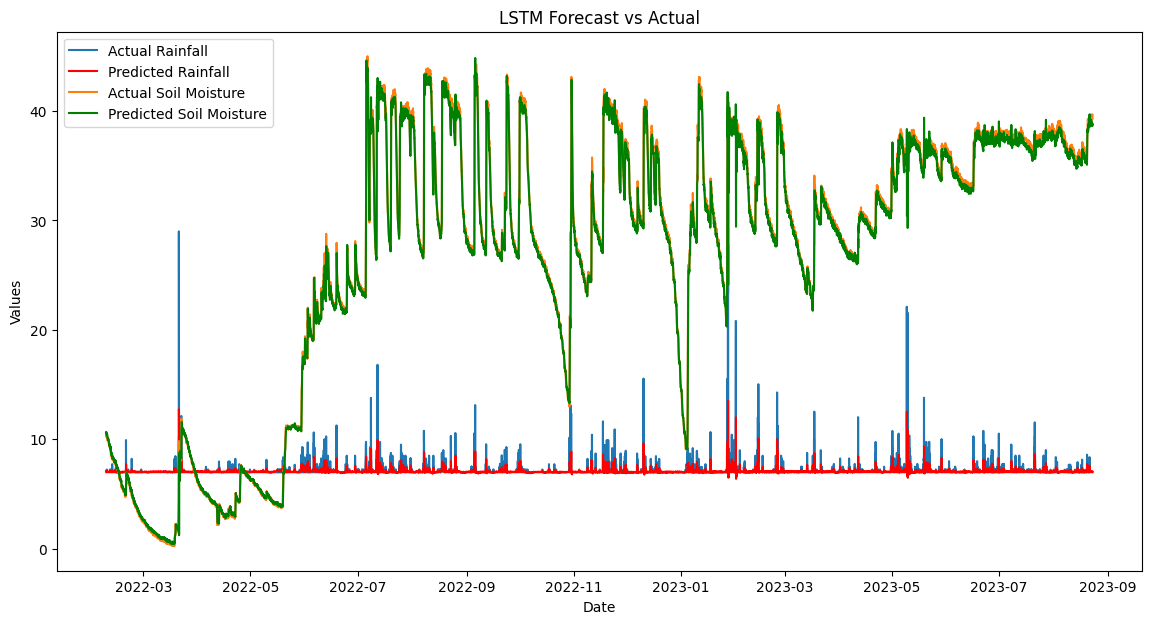

In [16]:
plt.figure(figsize=(14, 7))
plt.plot(temp_rain_soil.index[train_size + sequence_length:], test_y_transformed[:, -2], label='Actual Rainfall')
plt.plot(temp_rain_soil.index[train_size + sequence_length:], test_predictions_transformed[:, -2], color='red', label='Predicted Rainfall')
plt.plot(temp_rain_soil.index[train_size + sequence_length:], test_y_transformed[:, -1], label='Actual Soil Moisture')
plt.plot(temp_rain_soil.index[train_size + sequence_length:], test_predictions_transformed[:, -1], color='green', label='Predicted Soil Moisture')
plt.title('LSTM Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.show()

In [17]:
temp_rain_soil.head()

,Temp,Rain(mm),SoilMoist,SoilTemp,lag_Temp_1,lag_Rain(mm)_1,lag_Temp_2,lag_Rain(mm)_2,lag_Temp_3,lag_Rain(mm)_3,...,lag_Temp_10,lag_Rain(mm)_10,lag_Temp_11,lag_Rain(mm)_11,lag_Temp_12,lag_Rain(mm)_12,lag_Temp_13,lag_Rain(mm)_13,lag_Temp_14,lag_Rain(mm)_14
Timestamp (UTC+12:00),,,,,,,,,,,,,,,,,,,,,
2018-07-08 06:00:00,14.0,0.0,37.01425,11.075,13.0,0.0,13.0,0.0,13.0,0.0,...,14.0,0.0,14.0,0.0,15.0,0.0,15.0,0.0,15.0,0.0
2018-07-08 07:00:00,14.0,0.0,36.99425,11.050,14.0,0.0,13.0,0.0,13.0,0.0,...,14.0,0.0,14.0,0.0,14.0,0.0,15.0,0.0,15.0,0.0
2018-07-08 08:00:00,14.0,0.0,36.87725,11.025,14.0,0.0,14.0,0.0,13.0,0.0,...,13.0,0.0,14.0,0.0,14.0,0.0,14.0,0.0,15.0,0.0
2018-07-08 09:00:00,14.0,0.0,36.98375,11.025,14.0,0.0,14.0,0.0,14.0,0.0,...,13.0,0.0,13.0,0.0,14.0,0.0,14.0,0.0,14.0,0.0
2018-07-08 10:00:00,15.0,0.0,36.82200,11.050,14.0,0.0,14.0,0.0,14.0,0.0,...,13.0,0.0,13.0,0.0,13.0,0.0,14.0,0.0,14.0,0.0


In [18]:
PET = 3.0  # Potential Evapotranspiration in mm 
AWC = 150  # Available Water Capacity in mm
predicted_soilmoist = predicted_values[0, 1]  # Predicted Soil Moisture in mm

SMD = AWC - (predicted_soilmoist + PET)

In [19]:
def classify_drought_condition(smd):
    if smd < -130:
        return "Extremely dry"
    elif smd < -110:
        return "Severely dry"
    elif smd < -20:
        return "Severely drier than normal (imminent drought)"
    elif smd < -30:
        return "Extremely drier than normal (evident drought)"
    else:
        return "Normal"

drought_condition = classify_drought_condition(SMD)

print(f"Predicted Rain(mm): {predicted_rain}, Predicted SoilMoist: {predicted_soilmoist}, Predicted SoilTemp: {predicted_soiltemp}")
print(f"Soil Moisture Deficit (SMD): {SMD}")
print(f"Drought Condition: {drought_condition}")


Predicted Rain(mm): 7.0, Predicted SoilMoist: 0.0, Predicted SoilTemp: 34.97325
Soil Moisture Deficit (SMD): 147.0
Drought Condition: Normal


In [20]:
from datetime import datetime

predicted_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

predicted_data = {
    'Date': [predicted_date],
    'Predicted Rain(mm)': [predicted_rain],
    'Predicted SoilMoist': [predicted_soilmoist],
    'Predicted SoilTemp': [predicted_soiltemp],
    'SMD': [SMD],
    'Drought Condition': [drought_condition]
}

ecosystem_data = {
    'Ecosystem type': ['Manuka-tangle fern fen', 'Lakeshore turf', 'Flaxland'],
    'IUCN THREAT RANK': ['(CRITICALLY ENDANGERED)', '(CRITICALLY ENDANGERED)', '(CRITICALLY ENDANGERED)'],
    'risk of negative climate change effects': ['[Overall moderatelow risk]', '[Overall moderate-high risk]', '[Overall moderate risk]'],
    'Habitat type and distribution in New Zealand': [
        'Manuka fens are medium fertility wetlands that occur in places that are seasonally wet and dry. Common throughout New Zealand, the most extensive examples of this ecosystem in Auckland occur on Aotea. With concentrations at Kaitoke Swamp and wetlands in the Claris and Whangapoua area. This ecosystem type has been severely reduced in extent due to fire and drainage over the last 800 years. Around 390ha are mapped in the CEL, but the large wetlands on Aotea contribute 66% of the regional total. This makes this manuka fen more vulnerable to localised severe storms or climatic events that effect Aotea. As a wetland ecosystem manuka fens are inherently vulnerable to any increase in the frequency and/ or severity of droughts and floods which increase sediment and nutrient input. Weeds and fires are probably the biggest current threats to manuka fens (Singers et al. 2017), and climate effects that exacerbate these threats are a key risk for this ecosystem type.',
        'This ephemeral wetland ecosystem occupies a narrow band of habitat on shallow-gradient, fluctuating lake shorelines (Johnson 1972). Knowledge of its distribution in Auckland is incomplete, although we know it is very sparsely distributed as the environmental conditions in which it grows are very rare. Across the whole Auckland Region just 5ha of lakeshore turf is mapped in the CEL. Although this is almost certainly an under-estimate of its true extent it is a very rare ecosystem type. Its limited distribution may make it more vulnerable to climatic disturbances, however the ephemeral nature of lakeshore turf wetlands means they are well adapted to moving around the landscape in ‘search’ of habitat. If suitable habitat remains, then it is likely that this ecosystem will also remain.',
        'Flaxlands are swamps which occur on young landforms that regularly flood or receive surface flow from surrounding land (Bagnall and Ogle 1981). They are widespread throughout NZ, although their extent has been severely reduced by draining in most regions, including Auckland. Their regional distribution is very patchy; a total of only 54ha of flaxland is mapped in the current ecosystem layer, with an average size of just 0.7 ha. Many flaxland remnants are associated with coastal lakes and duneland wetlands, which means they are in an area that is particularly exposed to disturbance from increased frequency and/ or severity of storms, and sea-level rise. However, the relative vulnerability of individual remnants likely to be highly site specific.'
    ]
}

plant_data = {
    'Scientific Name': ['Agathis australis', 'Amphibromus fluitans', 'Anogramma leptophylla'],
    'Growth Form and Habit': ['Stout, coniferous forest tree', 'Weakly tufted, semi-aquatic grass', 'Small winter dormant fern'],
    'Threat Status': ['Nationally vulnerable', 'Nationally endangered', 'Nationally vulnerable'],
    'Climate Change Impact': ['Moderate risk', 'Moderate risk', 'Moderate-high risk']
}


In [21]:
# Calculate Soil Moisture Deficit (SMD)
AWC = 150  # Available Water Capacity in mm
PET = 3.0  # Potential Evapotranspiration in mm
SMD = AWC - (predicted_soilmoist + PET)


In [22]:
def classify_drought_condition(smd):
    if smd < -130:
        return "Extremely dry"
    elif smd < -110:
        return "Severely dry"
    elif smd < -20:
        return "Severely drier than normal (imminent drought)"
    elif smd < -30:
        return "Extremely drier than normal (evident drought)"
    else:
        return "Normal"
    
drought_condition = classify_drought_condition(SMD)
